# Prédiction d'age et de sexe à partir de voix humaine

## Introduction

Dans ce notebook, nous allons essayer de prédire l'âge et le sexe d'une personne à partir de sa voix. Pour cela, nous allons utiliser un ensemble de données de voix humaine disponible sur [Commonvoice](https://commonvoice.mozilla.org/fr/datasets ). Cet ensemble de données contient des enregistrements vocaux de personnes, chacun étant associé à un label indiquant le sexe de la personne (homme ou femme) et son âge. Nous allons entraîner un modèle de deeplearning sur ces données pour prédire le sexe et l'âge d'une personne à partir de sa voix.

1. [Paramètres](#Paramètres)
2. [Préparation des données](#Preparation-des-donnees)
3. [Traitements des audios](#Traitements-des-audios)
4. [Création du modèle](#Création-du-modèle)
5. [Entrainer le modèle](#4)
6. [Résultats](#5)




## Paramètres

On a une liste de paramètres qui vont nous permettre de configurer le modèle, les données et l'entraînement.

In [1]:
train_age_only = False
use_ordinal_age = False
use_early_stopping = False
features_length = 40

# Hyperparameters
loss_age_weight = 1
loss_genre_weight = 0.1
learning_rate = 0.00005
epochs = 25
batch_size = 128
num_age_classes = 7
train_ratio = 0.90

## Préparation des données

Le dataset choisis comportait énormément de lignes nous avons donc décidé dans un premier temps de supprimer toutes les lignes ou une valeur manquait. Puisque nous voulons prédire l'âge et le sexe nous avons ensuite trier le dataset pour voir la proportion de chaque sexe par tranche d'âge. A partir de ce résultat nous avons décidé de garder 10_000 lignes pour chaque catégorie d'âge avec une répartition égale d'hommes et de femmes.

In [2]:
data_path = r"D:\datasets\cv-corpus-19.0-2024-09-13-fr\cv-corpus-19.0-2024-09-13\fr"
data_path = r"/mnt/d/datasets/cv-corpus-19.0-2024-09-13-fr/cv-corpus-19.0-2024-09-13/fr"

/tmp/ipykernel_454575/1253693915.py:3: DtypeWarning: Columns (4,7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_table(f"{data_path}/validated.tsv")


path         0.000000
sentence     0.000000
age         36.111859
gender      30.482791
dtype: float64
with na :  (739181, 4)
without na :  (463265, 4)
percent of data lost : 37%


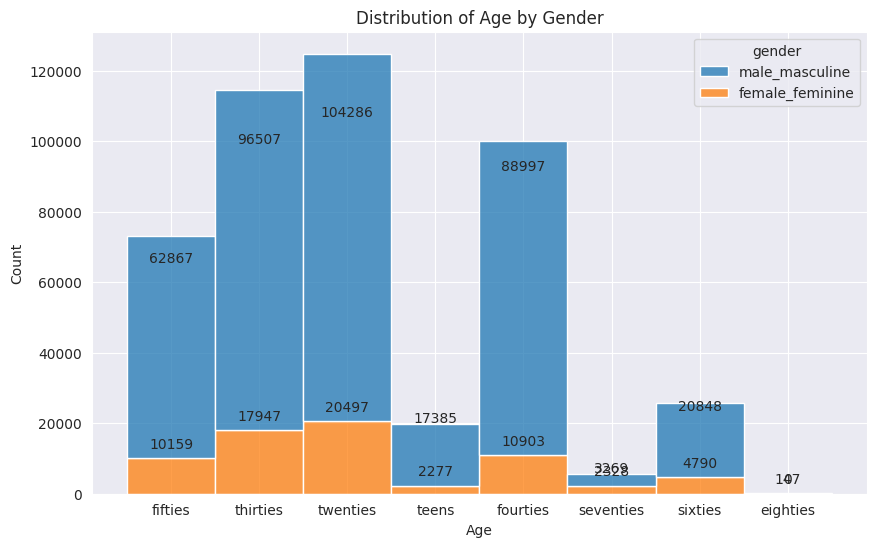

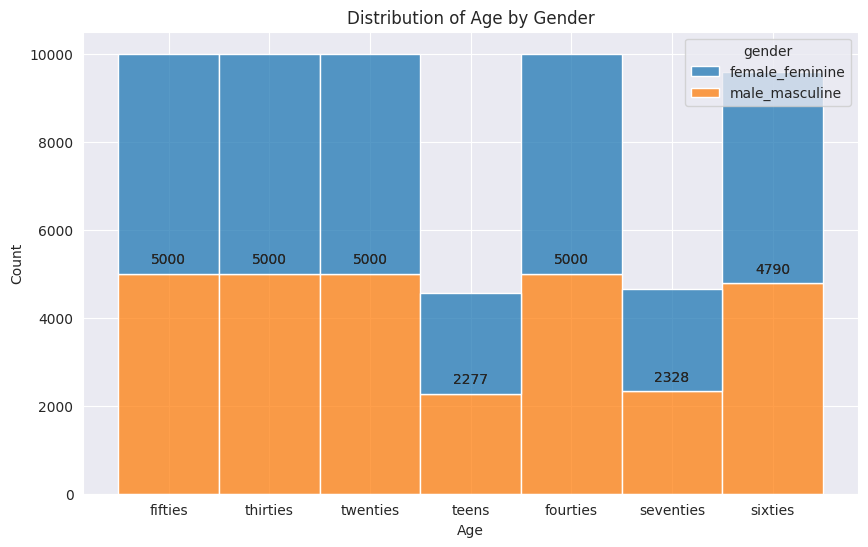

In [3]:
import pandas as pd

data = pd.read_table(f"{data_path}/validated.tsv")

keep_columns = ['path', 'sentence','age', 'gender',]
export_df = data.copy()[keep_columns]

#filter out the rows with missing values
import math
print(export_df.isnull().sum()/len(export_df)*100)
print("with na : ", export_df.shape)
print("without na : ",export_df.dropna().shape)
print(f"percent of data lost : {math.floor((export_df.shape[0] - export_df.dropna().shape[0])/export_df.shape[0]*100)}%")
filtered_df = export_df.copy().dropna()
filtered_df = filtered_df[filtered_df['gender'] != "non-binary"]
filtered_df = filtered_df[filtered_df['gender'] != "do_not_wish_to_say"]


# plot the distribution of age by gender
import matplotlib.pyplot as plt
import seaborn as sns
def show_distrib(df):
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(data=df, x='age', hue='gender', multiple='stack', stat='count')

    # Annotate the bars with their counts
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    plt.title('Distribution of Age by Gender')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.show()

show_distrib(filtered_df)


# export a csv with X rows by age category with the same distribution of men and woman
age_df_list = []
for age in filtered_df['age'].unique():
    df_age = filtered_df[filtered_df['age'] == age]
    df_male = df_age[df_age['gender'] == 'male_masculine']
    df_female = df_age[df_age['gender'] == 'female_feminine']
    count_per_gender = min(5000, len(df_female))
    df_tmp = pd.concat([df_female[:count_per_gender], df_male[:count_per_gender]])
    age_df_list.append(df_tmp)
export_df = pd.concat(age_df_list)
export_df.head()

show_distrib(export_df)

## Traitements des audios

Nous étions d'abord parti pour utiliser le spectrogramme des audios en normalisant l'audio et en modifiant la durée à 10 secondes. Cependant, les résultats obtenus n'étaient pas pertinent (~0.23 d'accuracy) nous avons donc décidé de changer de méthode. Nous avons utilisé la librairie librosa pour transformer les audios en MFCC (Mel-Frequency Cepstral Coefficients) qui sont des caractéristiques audio qui représentent le spectre de puissance d'un son, utilisées pour l'analyse et la reconnaissance vocale. Nous avons aussi fait la moyenne des MFCC pour chaque audio pour réduire la dimension des données.

> preprocessing/simple_preprocessing.py

Cette étape prenant plusieurs heures, elle sera exécutée dans un script séparé.

## Création du dataset

Nous avons créé un dataset avec les MFCC moyens de chaque audio et les labels associés. Nous avons ensuite divisé ce dataset en un ensemble d'entraînement et un ensemble de test. On utilise Tensorflow pour charger les données et les préparer pour l'entraînement.

Pour encoder le genre nous avons choisi un encodage binaire 0 (male) et 1 (femelle).
Pour l'âge nous avons essayé plusieurs encodages : 
- l'encodage ordinnal semble être une option logique pour l'âge, mais les résultats n'étaient pas ceux espérés .
- Le hot-one encoding a donné de meilleurs résultats.

In [4]:
from sklearn.model_selection import train_test_split


def preprocess_label_data(label_data, keep_age=False):
    gender_dict = {
        'male_masculine': 0,
        'female_feminine': 1
    }
    age_dict = {
        'teens': 0,
        'twenties': 1,
        'thirties': 2,
        'fourties': 3,
        'fifties': 4,
        'sixties': 5,
        'seventies': 6
    }
    label_data = label_data.copy()
    mfcc_features = []
    for i in range(features_length):
        mfcc_features.append(label_data[f'mfcc_{i}'])
        label_data = label_data.drop(f'mfcc_{i}', axis=1)
    label_data['mfcc_features'] = list(np.asarray(mfcc_features).T)
    if use_ordinal_age:
        label_data['age'] = label_data['age'].map(age_dict)
    else:
        dummies = pd.get_dummies(label_data['age'])
        dummies = dummies[[*age_dict.keys()]]
        label_data = pd.concat([label_data, dummies], axis=1)
        if not keep_age:
            label_data = label_data.drop('age', axis=1)
    label_data['gender'] = label_data['gender'].map(gender_dict)
    return label_data

Pour la création du datasets nous avons plusieurs étapes :
- Charger les données.
- Encoder les labels.
- Diviser les données en un ensemble d'entraînement et un ensemble de test.
- Créer des datasets TensorFlow à partir des données.

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf


def load_csv_data(csv_path):
    """
    Load CSV data into a DataFrame with specific columns.
    """
    df = pd.read_csv(csv_path)
    return df


def create_dataset(csv_path, batch_size, num_age_classes, train_ratio=0.8, random_state=0):
    """
    Create a tf.data.Dataset from a CSV file.
    """
    # Load CSV and preprocess
    df = load_csv_data(csv_path)
    df = preprocess_label_data(df)

    # Split the data
    train_data, val_data = train_test_split(df, train_size=train_ratio, random_state=random_state,
                                            stratify=df['gender'])
    print(f"Train data: {len(train_data)} samples")
    print(f"Validation data: {len(val_data)} samples")

    # Convert columns to tensors
    def convert_to_tensors(data):
        features = data['mfcc_features']
        features = tf.convert_to_tensor(np.stack(features), dtype=tf.float32)
        ages = tf.convert_to_tensor(data['age'] if use_ordinal_age else data.iloc[:, 4:].values,
                                    dtype=tf.float32)  # Assuming age columns start from index 3
        if not train_age_only:
            genders = tf.convert_to_tensor(data['gender'].values, dtype=tf.int32)
            return features, genders, ages
        else:
            return features, ages

    if not train_age_only:
        train_features, train_genders, train_ages = convert_to_tensors(train_data)
        val_features, val_genders, val_ages = convert_to_tensors(val_data)
        # Create datasets from tensors
        train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_genders, train_ages))
        val_dataset = tf.data.Dataset.from_tensor_slices((val_features, val_genders, val_ages))
        # Parse rows, and batch
        train_dataset = (
            train_dataset
            .map(lambda path, gender, age: tf_parse_row(path, gender, age, num_age_classes),
                 num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE)  # Prefetch for efficient data loading
        )

        val_dataset = (
            val_dataset
            .map(lambda path, gender, age: tf_parse_row(path, gender, age, num_age_classes),
                 num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE)  # Prefetch for efficient data loading
        )
    else:
        train_features, train_ages = convert_to_tensors(train_data)
        val_features, val_ages = convert_to_tensors(val_data)
        # Create datasets from tensors
        train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_ages))
        val_dataset = tf.data.Dataset.from_tensor_slices((val_features, val_ages))

        # Parse rows, and batch
        train_dataset = (
            train_dataset
            .map(lambda features, age: tf_parse_row(features, None, age, num_age_classes),
                 num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE)  # Prefetch for efficient data loading
        )

        val_dataset = (
            val_dataset
            .map(lambda features, age: tf_parse_row(features, None, age, num_age_classes),
                 num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE)  # Prefetch for efficient data loading
        )
    return train_dataset, val_dataset


def tf_parse_row(features, gender_label, age_label, num_age_classes):
    """
    Wrapper to use the parse_row function with TensorFlow.
    """

    # Set shapes for TensorFlow to understand
    features.set_shape([features_length])  # Ajustez cette forme en fonction de vos données
    age_label.set_shape([] if use_ordinal_age else [num_age_classes])
    labels = {"age": age_label}
    if not train_age_only:
        gender_label.set_shape([])
        labels['gender'] = gender_label
    return features, labels

2024-12-09 18:03:07.637196: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 18:03:07.647912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733763787.658387  454575 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733763787.661823  454575 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 18:03:07.674212: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [6]:
csv_path = f"{data_path}/features.csv"

train_dataset, val_dataset = create_dataset(csv_path, batch_size, num_age_classes, train_ratio)

Train data: 131031 samples
Validation data: 14559 samples


I0000 00:00:1733763791.420000  454575 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


## Création du modèle

Nous avons voulu reconnaitre des patternes dans les audios pour cela on a choisi des couches de convolution qui sont très utilisées pour la reconnaissance de patternes. Nous avons combiné ces couches avec des couches de maxpooling pour réduire la dimension des données et des couches de dropout pour éviter l'overfitting. 
Des couches de dense ont été ajoutées pour la classification des différents patterns reconnus. 

Pour les fonctions de pertes nous avons utilisé la Binary Crossentropy pour le sexe et la Categorical Crossentropy pour l'age. Nous avons aussi jouer sur le poid de chaque fonction de perte pour guider le modèle dans son apprentissage.

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models, initializers


class ConvBlock(layers.Layer):
    def __init__(self, filters, kernel_size, strides=1, padding='same', activation='relu',
                 kernel_initializer='he_normal', batch_norm=True, max_pool=True, dropout_rate=0.0):
        super(ConvBlock, self).__init__()
        self.conv1 = layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            kernel_initializer=kernel_initializer
        )
        self.conv2 = layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            kernel_initializer=kernel_initializer
        )
        self.batch_norm = layers.BatchNormalization() if batch_norm else None
        self.activation = layers.Activation(activation)
        self.max_pool = layers.MaxPooling1D(pool_size=2, strides=2, padding='same') if max_pool else None
        self.dropout = layers.Dropout(dropout_rate) if dropout_rate > 0 else None

    def call(self, inputs, training=False):
        x = self.conv1(inputs, training=training)
        x = self.conv2(x, training=training)
        if self.batch_norm:
            x = self.batch_norm(x, training=training)
        x = self.activation(x)
        if self.max_pool:
            x = self.max_pool(x)
        if self.dropout:
            x = self.dropout(x, training=training)
        return x


class AudioAgeAndGenderClassifier(tf.keras.Model):
    def __init__(self, *args, **kwargs):
        super(AudioAgeAndGenderClassifier, self).__init__(*args, **kwargs)
        self.blocks = [
            # ConvBlock(filters=16, kernel_size=3, strides=1, padding='same', activation='relu',
            #           kernel_initializer='he_normal', batch_norm=False, max_pool=True, dropout_rate=0.0),
            ConvBlock(filters=32, kernel_size=3, strides=1, padding='same', activation='relu',
                      kernel_initializer='he_normal', batch_norm=False, max_pool=True, dropout_rate=0.0),
            ConvBlock(filters=64, kernel_size=3, strides=1, padding='same', activation='relu',
                      kernel_initializer='he_normal', batch_norm=False, max_pool=True, dropout_rate=0.1),
            ConvBlock(filters=128, kernel_size=3, strides=1, padding='same', activation='relu',
                      kernel_initializer='he_normal', batch_norm=False, max_pool=True, dropout_rate=0.1),
            ConvBlock(filters=256, kernel_size=3, strides=1, padding='same', activation='relu',
                      kernel_initializer='he_normal', batch_norm=True, max_pool=True, dropout_rate=0.2),
            ConvBlock(filters=512, kernel_size=3, strides=1, padding='same', activation='relu',
                      kernel_initializer='he_normal', batch_norm=True, max_pool=True, dropout_rate=0.2),
        ]

        self.reduction_layer = layers.Flatten()
        self.dense = layers.Dense(128, activation='relu')
        self.age_output = layers.Dense(1 if use_ordinal_age else num_age_classes,
                                       activation="relu" if use_ordinal_age else 'softmax')
        if not train_age_only:
            self.gender_output = layers.Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        x = tf.expand_dims(inputs, axis=-1)
        # x = inputs
        for block in self.blocks:
            x = block(x, training=training)

        x = self.reduction_layer(x)
        x = self.dense(x, training=training)
        age_pred = self.age_output(x)

        if not train_age_only:
            gender_pred = self.gender_output(x)
            return {"age": age_pred, "gender": gender_pred}
        else:
            return {"age": age_pred}


# Instantiate the model
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"Using GPU: {device_name}")
else:
    print("Using CPU")

Using GPU: /device:GPU:0


I0000 00:00:1733763791.755389  454575 gpu_device.cc:2022] Created device /device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


## Entrainer le modèle

Une fois le modèle définit on peut l'entrainer. Nous avons fait  plusieurs entrainments en faisant varier les paramètres pour comparer l'influence de ces derniers sur les résultats. Pour pouvoir finalement trouver les meilleurs paramètres pour notre modèle.

L'âge étant un label plus complexe à prédire que le genre on peut choisir d'entrainer le modèle que sur l'âge pour mieux régler les hyperparamètres.

In [12]:
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def age_loss_function(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


# Compile the model
def compile_model(model, learning_rate=0.001):
    # Define separate losses for age and gender
    losses = {
        "age": age_loss_function if use_ordinal_age else tf.keras.losses.CategoricalCrossentropy(),
    }
    metrics = {
        "age": [
            tf.keras.metrics.MeanSquaredError() if use_ordinal_age else tf.keras.metrics.CategoricalAccuracy,
            # *[tf.keras.metrics.Recall(class_id=i, name=f'{i}') for i in range(num_age_classes)]
        ],
    }
    if not train_age_only:
        losses["gender"] = tf.keras.losses.BinaryCrossentropy()
        metrics["gender"] = [tf.keras.metrics.BinaryAccuracy()]

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=losses,
        loss_weights=[loss_age_weight, loss_genre_weight] if not train_age_only else [loss_age_weight],
        metrics=metrics,
    )
    return model


def plot_confusion_matrix(y_test_classes, y_pred_classes, display_labels, title="Confusion Matrix"):
    plt.figure(figsize=(3, 1))
    # Compute the confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)

    # Optionally normalize the confusion matrix
    # cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    # Plot the matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)

    plt.show()


def retrieve_labels(dataset):
    all_labels = []
    for features, labels in dataset:
        all_labels.append(labels)
    print(np.asarray(all_labels).shape)
    return np.concatenate(all_labels, axis=0)


def print_example_output(model, dataset):
    # Get the model predictions
    predictions = {"age": [], "gender": []}
    labels = {"age": [], "gender": []}
    for features, labels_ in dataset:
        for key in labels_.keys():
            results = model.predict(features, verbose=0)
            predictions[key].extend(results[key])
            labels[key].extend(labels_[key].numpy())
    if not use_ordinal_age:
        predictions["age"] = np.argmax(predictions["age"], axis=1)
        labels["age"] = np.argmax(labels["age"], axis=1)
    labels_names = ['teens', 'twenties',
                    'thirties', 'fourties',
                    'fifties', 'sixties',
                    'seventies']
    precisions, recall, f1_score, _ = sklearn.metrics.precision_recall_fscore_support(labels["age"], predictions["age"])
    for i in range(num_age_classes):
        print(f"Age {i + 1}: Precision: {precisions[i]}, Recall: {recall[i]}, F1 Score: {f1_score[i]}")
    plot_confusion_matrix(labels["age"], predictions["age"], labels_names,
                          title="Age Confusion Matrix")
    print("\n\n\n\n")
    if not train_age_only:
        precision, recall, f1_score, _ = sklearn.metrics.precision_recall_fscore_support(labels["gender"], np.asarray(predictions["gender"]) > 0.5)
        print(f"Male: Precision: {precision[0]}, Recall: {recall[0]}, F1 Score: {f1_score[0]}")
        print(f"Femelle: Precision: {precision[1]}, Recall: {recall[1]}, F1 Score: {f1_score[1]}")
        predictions["gender"] = np.asarray(predictions["gender"]) > 0.5
        plot_confusion_matrix(labels["gender"], predictions["gender"], ['male', 'female'],
                              title="Gender Confusion Matrix")


# Train the model
def train_model(model, dataset, validation_dataset, epochs, batch_size, verbose=0, print_confusion_matrix=False):
    # Define callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            "train/best_model.weights.h5", save_best_only=True, monitor="loss", save_weights_only=True # Should be val_loss but we don't want to evaluate the model on the validation twice (if we print the confusion matrix)
        ),
        tf.keras.callbacks.TensorBoard(log_dir="./logs"),
    ]
    if print_confusion_matrix:
        callbacks.append(
            tf.keras.callbacks.LambdaCallback(
                on_epoch_end=lambda epoch, logs: print_example_output(model, validation_dataset)
            )
        )
    # if use_early_stopping:
    #     callbacks.append(
    #         tf.keras.callbacks.EarlyStopping(
    #             monitor="loss", patience=3
    #         ), )

    # Train the model
    history = model.fit(
        dataset,
        # validation_data=validation_dataset,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=verbose,
    )
    return history

In [9]:
# Train the model
model = AudioAgeAndGenderClassifier()
model = compile_model(model, learning_rate)
history = train_model(model, train_dataset, val_dataset, epochs, batch_size, verbose=2)

Epoch 1/25


I0000 00:00:1733763796.627439  455072 service.cc:148] XLA service 0x7f3a780189a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733763796.627559  455072 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-12-09 18:03:16.712003: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733763797.312179  455072 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1733763810.097272  455072 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1024/1024 - 54s - 53ms/step - age_categorical_accuracy: 0.1779 - age_loss: 1.9404 - gender_binary_accuracy: 0.5670 - gender_loss: 0.0682 - loss: 2.0086
Epoch 2/25
1024/1024 - 18s - 17ms/step - age_categorical_accuracy: 0.2156 - age_loss: 1.8596 - gender_binary_accuracy: 0.7351 - gender_loss: 0.0550 - loss: 1.9146
Epoch 3/25
1024/1024 - 22s - 21ms/step - age_categorical_accuracy: 0.2738 - age_loss: 1.7701 - gender_binary_accuracy: 0.8056 - gender_loss: 0.0439 - loss: 1.8140
Epoch 4/25
1024/1024 - 11s - 11ms/step - age_categorical_accuracy: 0.3369 - age_loss: 1.6512 - gender_binary_accuracy: 0.8282 - gender_loss: 0.0401 - loss: 1.6912
Epoch 5/25
1024/1024 - 13s - 13ms/step - age_categorical_accuracy: 0.4009 - age_loss: 1.5247 - gender_binary_accuracy: 0.8382 - gender_loss: 0.0383 - loss: 1.5630
Epoch 6/25
1024/1024 - 17s - 16ms/step - age_categorical_accuracy: 0.4567 - age_loss: 1.4059 - gender_binary_accuracy: 0.8443 - gender_loss: 0.0371 - loss: 1.4430
Epoch 7/25
1024/1024 - 15s - 15ms

## Résultats

Après 25 epochs, nous avons obtenus les résultats suivants:

Age 1: Precision: 0.9340788699234844, Recall: 0.9104991394148021, F1 Score: 0.9221382916908774
Age 2: Precision: 0.8825286212045794, Recall: 0.7897550111358574, F1 Score: 0.8335684062059239
Age 3: Precision: 0.9047376464595007, Recall: 0.8080072793448589, F1 Score: 0.8536409516943042
Age 4: Precision: 0.8453299057412168, Recall: 0.8699294532627866, F1 Score: 0.8574532811820947
Age 5: Precision: 0.836542400655469, Recall: 0.9231464737793852, F1 Score: 0.8777133032452181
Age 6: Precision: 0.9151023890784983, Recall: 0.955456570155902, F1 Score: 0.9348441926345609
Age 7: Precision: 0.9293386093838327, Recall: 0.9975728155339806, F1 Score: 0.9622475856014048


<Figure size 300x100 with 0 Axes>

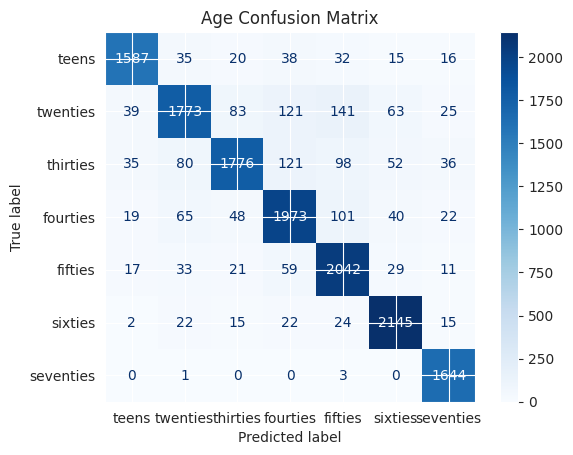






Male: Precision: 0.8971506105834464, Recall: 0.9082417582417582, F1 Score: 0.9026621160409556
Femelle: Precision: 0.9070802615106413, Recall: 0.8958648165956862, F1 Score: 0.9014376555156207


<Figure size 300x100 with 0 Axes>

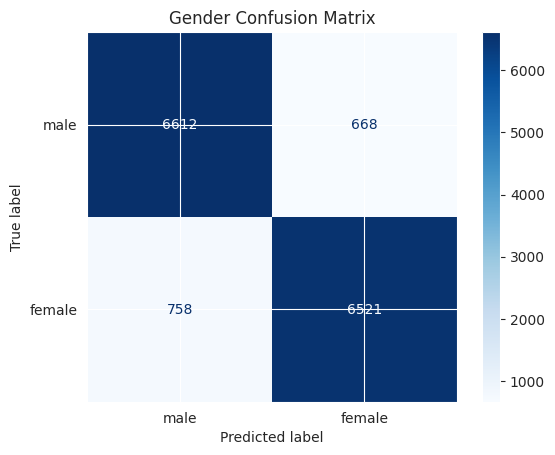

In [13]:
print_example_output(model, val_dataset)

Extrait:
![Confusion Matrix for Age](age_confusion_matrix_epoch_25.png)

    - Age 1: Precision: 0.9340788699234844, Recall: 0.9104991394148021, F1 Score: 0.9221382916908774
    - Age 2: Precision: 0.8825286212045794, Recall: 0.7897550111358574, F1 Score: 0.8335684062059239
    - Age 3: Precision: 0.9047376464595007, Recall: 0.8080072793448589, F1 Score: 0.8536409516943042
    - Age 4: Precision: 0.8453299057412168, Recall: 0.8699294532627866, F1 Score: 0.8574532811820947
    - Age 5: Precision: 0.836542400655469, Recall: 0.9231464737793852, F1 Score: 0.8777133032452181
    - Age 6: Precision: 0.9151023890784983, Recall: 0.955456570155902, F1 Score: 0.9348441926345609
    - Age 7: Precision: 0.9293386093838327, Recall: 0.9975728155339806, F1 Score: 0.9622475856014048

![Confusion Matrix for Gender](gender_conf_matrix_epoch_25.png)

    - Male: Precision: 0.8971506105834464, Recall: 0.9082417582417582, F1 Score: 0.9026621160409556
    - Femelle: Precision: 0.9070802615106413, Recall: 0.8958648165956862, F1 Score: 0.9014376555156207

Les résultats sont plutôt satisfaisants, le modèle semble avoir réussi à extraires les bonnes caractéristiques.

### Les futurs améliorations possibles
- En utilisant la même méthodologie, essayer de voir si notre architecture est également capable d'extraire les accents des personnes. Mais cela requiererais des données plus précises sur l'accent entendu, ce qui n'est pas toujours très fiable.